# LightGBM Prediction of Home Credit Default Risk
Introduction: Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

The basis of this kernel was forked from Olivier on Kaggle, with additional added features that increased ROC AUC from 0.792 to 0.8005 local CV.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

https://www.kaggle.com/c/home-credit-default-risk

The objective of this is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)



In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Features
Different groups of features either to delete or add after a few runs of LightGBM feature importance analysis

In [2]:
features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY'
]

*Top features from original run*

In [3]:
top200=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'buro_score_sum', 'prev_score_max',
       'buro_score_mean', 'external_1_refill', 'EXT_SOURCE_2', 'INTEREST',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'buro_score_max', 'prev_score_last',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'DOWN_PAYMENT', 'EXT_SOURCE_3',
       'buro_score_recent2y_sum', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'CNT_PAYMENT', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 / DAYS_BIRTH', 'DAYS_BIRTH', 'LATE_PAYMENT',
       'app EXT_SOURCE_3 / DAYS_BIRTH', 'CRED_UTIL_2',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'external_3_refill', 'CODE_GENDER',
       'AMT_CREDIT', 'NEW_CREDIT_TO_GOODS_RATIO',
       'NEW_CREDIT_TO_ANNUITY_RATIO/3', 'NEW_SOURCES_PROD', 'DAYS_ID_PUBLISH',
       'INSTAL_AMT_PAYMENT_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'NEW_ANNUITY_TO_INCOME_RATIO',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INTEREST_SHARE', 'EXT_SOURCE_1',
       'buro_score_var', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
       'DAYS_EMPLOYED', 'POS_MONTHS_BALANCE_MAX', 'AGE_INT',
       'CLOSED_DAYS_CREDIT_MAX', 'prev_score_var',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'app EXT_SOURCE_1 * EXT_SOURCE_3',
       'OWN_CAR_AGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'POS_MONTHS_BALANCE_MEAN',
       'INSTAL_AMT_INSTALMENT_SUM',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NEW_CAR_TO_BIRTH_RATIO', 'APPROVED_DAYS_DECISION_MAX',
       'INSTAL_DPD_MEAN', 'buro_score_last', 'POS_COUNT', 'DAYS_REGISTRATION',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'ACTIVE_DAYS_CREDIT_MAX', 'PREV_DAYS_DECISION_MAX',
       'NAME_FAMILY_STATUS_Married', 'PREV_length_of_loan_MEAN',
       'BURO_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'NEW_CAR_TO_EMPLOY_RATIO', 'INSTAL_AMT_PAYMENT_MIN',
       'NEW_CREDIT_TO_INCOME_RATIO', 'PREV_days_late_due_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_PHONE_TO_EMPLOY_RATIO',
       'ACTIVE_AMT_CREDIT_SUM_MAX', 'prev_score_recent2y_sum',
       'NEW_PHONE_TO_BIRTH_RATIO', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX', '60_DAYSAMT_PAYMENT_MIN',
       'INSTAL_DBD_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'BURO_DAYS_CREDIT_MAX',
       'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN', 'ACTIVE_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'PREV_days_late_due_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MEAN', 'NEW_DOC_IND_KURT',
       'INSTAL_AMT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 
        'NEW_SCORES_STD', 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'INSTAL_PAYMENT_PERC_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_DBD_MAX', 'prev_score_sum',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'PREV_APP_CREDIT_PERC_VAR',
       'BURO_STATUS_0_MEAN_MEAN', 'INSTAL_PAYMENT_PERC_MEAN',
       'BURO_AMT_CREDIT_DEBT_RATE_MEAN', 'APPROVED_APP_CREDIT_PERC_VAR',
       'CLOSED_DAYS_CREDIT_VAR', 'CLOSED_AMT_CREDIT_SUM_SUM',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'PREV_length_of_loan_MAX', 'BURO_DAYS_CREDIT_MEAN',
       'INSTAL_PAYMENT_DIFF_SUM', 'BURO_AMT_CREDIT_SUM_MAX',
       'PREV_CNT_PAYMENT_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN', 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
       'APPROVED_INTEREST_SHARE_PREV_MEAN', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'BURO_AMT_CREDIT_SUM_MEAN', 'NEW_INC_PER_CHLD', 'INSTAL_DPD_SUM',
       'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
       'AMT_INCOME_TOTAL', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
       'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN', 'INSTAL_AMT_INSTALMENT_MAX',
       'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'APPROVED_INTEREST_PREV_MAX',
       'CLOSED_AMT_CREDIT_SUM_MAX', 'ACTIVE_DAYS_CREDIT_MIN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MAX',
       'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX',
       'POS_MONTHS_BALANCE_MIN', 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
       'PREV_INTEREST_SHARE_PREV_MEAN', 'APPROVED_CNT_PAYMENT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MIN', 'INSTAL_AMT_INSTALMENT_MEAN',
       'ACTIVE_DAYS_CREDIT_VAR', 'PREV_INTEREST_PREV_MAX',
       'INSTAL_AMT_PAYMENT_MAX', 'APPROVED_AMT_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
       'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN', 'APPROVED_DAYS_DECISION_MIN',
       'BURO_CREDIT_TYPE_Consumer credit_MEAN',
       '60_DAYSDAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_ANNUITY_MIN',
       'PREV_AMT_ANNUITY_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'PREV_AMT_DOWN_PAYMENT_MEAN',
       'PREV_HOUR_APPR_PROCESS_START_MEAN',
       'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_DEBT_RATE_SUM',
       'INSTAL_COUNT', 'TOTALAREA_MODE', 'BURO_DAYS_CREDIT_VAR',
       'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN', '60_DAYSAMT_INSTALMENT_SUM',
       'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'APPROVED_length_of_loan_MEAN',
       'INSTAL_PAYMENT_PERC_VAR', 'BURO_STATUS_C_MEAN_MEAN',
       'INSTAL_PAYMENT_DIFF_MAX', 'PREV_APP_CREDIT_PERC_MAX',
       'PREV_AMT_ANNUITY_MIN', 'APPROVED_CNT_PAYMENT_SUM', 'FLAG_WORK_PHONE',
       'APPROVED_APP_CREDIT_PERC_MIN', 'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_MONTHS_BALANCE_SIZE_SUM',
       'REGION_RATING_CLIENT_W_CITY_3', 'PREV_DAYS_DECISION_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
       'APPROVED_INTEREST_PREV_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       '90_DAYSAMT_PAYMENT_MIN', 'BURO_DAYS_CREDIT_MIN', '60_DAYSDBD_MEAN']

spearman reduced collinearity

In [4]:
sp=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'EXT_SOURCE_3',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'CODE_GENDER',
 'AMT_CREDIT',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'NEW_CREDIT_TO_ANNUITY_RATIO/3',
 'NEW_SOURCES_PROD',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'REGION_POPULATION_RELATIVE',
 'POS_MONTHS_BALANCE_MAX',
 'AGE_INT',
 'CLOSED_DAYS_CREDIT_MAX',
 'prev_score_var',
 'BURO_AMT_CREDIT_DEBT_RATE_VAR',
 'OWN_CAR_AGE',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NEW_CAR_TO_BIRTH_RATIO',
 'APPROVED_DAYS_DECISION_MAX',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'DAYS_REGISTRATION',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
 'ACTIVE_DAYS_CREDIT_MAX',
 'NAME_FAMILY_STATUS_Married',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'INSTAL_AMT_PAYMENT_MIN',
 'NEW_CREDIT_TO_INCOME_RATIO',
 'PREV_days_late_due_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'prev_score_recent2y_sum',
 'NEW_PHONE_TO_BIRTH_RATIO',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MEAN',
 'NEW_DOC_IND_KURT',
 'INSTAL_AMT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'NEW_SCORES_STD',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'INSTAL_PAYMENT_PERC_SUM',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_APP_CREDIT_PERC_VAR',
 'BURO_STATUS_0_MEAN_MEAN',
 'INSTAL_PAYMENT_PERC_MEAN',
 'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'PREV_length_of_loan_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN',
 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_AMT_INSTALMENT_MAX',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_MONTHS_BALANCE_MIN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_VAR',
 'APPROVED_AMT_CREDIT_MAX',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'BURO_CREDIT_TYPE_Consumer credit_MEAN',
 '60_DAYSDAYS_ENTRY_PAYMENT_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 'TOTALAREA_MODE',
 'BURO_DAYS_CREDIT_VAR',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_PAYMENT_PERC_VAR',
 'BURO_STATUS_C_MEAN_MEAN',
 'PREV_APP_CREDIT_PERC_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'FLAG_WORK_PHONE',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'REGION_RATING_CLIENT_W_CITY_3',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
 'APPROVED_INTEREST_PREV_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 '60_DAYSDBD_MEAN']

In [5]:
sp1=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'prev_score_max',
 'external_1_refill',
 'EXT_SOURCE_2',
 'INTEREST',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'buro_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'DOWN_PAYMENT',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'AMT_ANNUITY',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'DAYS_BIRTH',
 'LATE_PAYMENT',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'CRED_UTIL_2',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'external_3_refill',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_SUM',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'OWN_CAR_AGE',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_MEAN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_DPD_MEAN',
 'POS_COUNT',
 'ACTIVE_DAYS_CREDIT_MAX',
 'PREV_length_of_loan_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_days_late_due_MEAN',
 'NEW_PHONE_TO_EMPLOY_RATIO',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 '60_DAYSAMT_PAYMENT_MIN',
 'DAYS_LAST_PHONE_CHANGE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_AMT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DBD_MAX',
 'prev_score_sum',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_APP_CREDIT_PERC_VAR',
 'CLOSED_DAYS_CREDIT_VAR',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_DAYS_CREDIT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'APPROVED_INTEREST_SHARE_PREV_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'NEW_INC_PER_CHLD',
 'APPROVED_INTEREST_PREV_MAX',
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN',
 'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MEAN',
 '60_DAYSAMT_INSTALMENT_SUM',
 'APPROVED_APP_CREDIT_PERC_MIN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN']

### LightGBM with KFold CV - 5 folds

In [6]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    #using all features
    #feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]
    
    #using spearman rank 1
    feats = sp1
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8, #5, #8
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, #39.3259775, #60
            'seed': 19,
            'verbose': -1,
            'feature_fraction':0.4,
            'metric': 'auc'
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        oof_df=pd.DataFrame()
        oof_df['SK_ID_CURR']=train_df['SK_ID_CURR'].iloc[valid_idx]
        oof_df['TARGET'] = oof_preds[valid_idx]
        oof_df.head()
        #oof_df[['SK_ID_CURR', 'TARGET']].to_csv(r'fold{:02d}.csv'.format(n_fold+1), index= False)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    feature_importance_df.to_csv(r'fi.csv')
    return feature_importance_df

In [7]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')


### Main function

(356251, 840)
(356251, 840)
Starting LightGBM. Train shape: (307507, 840), test shape: (48744, 840)
Fold  1 AUC : 0.798337
Fold  2 AUC : 0.796655
Fold  3 AUC : 0.796971
Fold  4 AUC : 0.798697
Fold  5 AUC : 0.799203
Full AUC score 0.797966


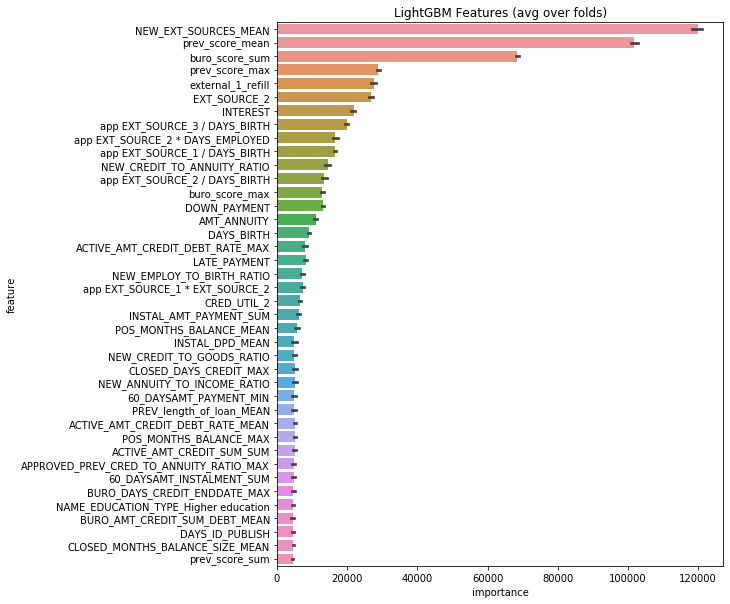

In [8]:
df=pd.read_csv('o_full_train')
        
if __name__ == "__main__":
    submission_file_name = "submission_with selected_features.csv"
    print(df.shape)
    gc.collect()
    print(df.shape)
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False)